# Using predictive covariates to estimate time trends with DisMod-MR

The goal of this document is to demonstrate how DisMod-MR can produce estimates of time trends using predictive covariates.

To demonstrate this clearly, I have used simulated data: the true age pattern is linear, and prevalence levels vary over time in a way completely explained by covariates $x_1$ and $x_2$.  $x_1$ is increasing roughly linearly over time, while $x_2$ is changing randomly over time.

In [6]:
import numpy as np, matplotlib.pyplot as plt, pymc as mc, pandas as pd, dismod_mr

In [7]:
np.random.seed(123456)

In [8]:
ANY = 'Any'
LATE = 'Late'
EARLY = 'Early'
INTERMEDIATE = 'Intermediate'
EAR_INTER = 'Early to intermediate'

M = 'Male'
F = 'Female'

In [54]:
import pandas as pd

# read with openpyxl (no need for xlrd)
df = pd.read_excel('full_data.xlsx',
                   sheet_name='Prevalence',
                   engine='openpyxl')

# drop any true missing Sex/Age rows
df = df.dropna(subset=['Sex', 'Age'])

# filter for Intermediate AMD in males
mask = (
    (df['Type (Any, early to intermediate, late-wet, late-dry)'] == EARLY) &
    (df['Sex'] == M)
)
df = df.loc[mask].copy()

# keep only the cols you want
cols = ['age_start', 'age_end', 'year_start', 'year_end',
        'Sample size', 'proportion']
df = df.loc[:, cols]

df['year'] = (
    df[['year_start','year_end']]
      .mean(axis=1)
      .round()
      .astype(int)
)


# print text repr to avoid HTML formatting bugs
print(df.head())
print(df.tail())


      age_start  age_end  year_start  year_end  Sample size  proportion  year
1759       50.0     95.0      1997.0    1999.0       1088.0    0.104779  1998
1762       50.0     59.0      1997.0    1999.0        491.0    0.069246  1998
1765       60.0     69.0      1997.0    1999.0        347.0    0.077810  1998
1768       70.0     79.0      1997.0    1999.0        214.0    0.219626  1998
1771       80.0     95.0      1997.0    1999.0         36.0    0.166667  1998
      age_start  age_end  year_start  year_end  Sample size  proportion  year
5554       60.0     69.0      2017.0    2019.0       1211.0    0.113130  2018
5555       70.0     95.0      2017.0    2019.0        435.0    0.121839  2018
5556       50.0     95.0      2017.0    2019.0       3544.0    0.106095  2018
5629       55.0     95.0      2013.0    2019.0      52447.0    0.024692  2016
5664       55.0     95.0      2013.0    2019.0      52447.0    0.024692  2016


In [55]:
print(min(df['year']))
print(max(df['year']))

1998
2018


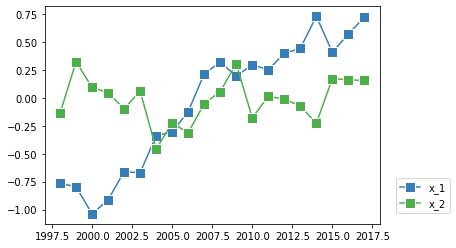

In [61]:
# range of time for simulation
# years = np.arange(1990,2011)
years = np.arange(1998,2018)

# covariates that completely explain variation of prevalence over time
x_1 = mc.rnormal((years-2008) / 10., .2**-2)
x_2 = mc.rnormal(0.*years, .2**-2)

# these covariates change roughly linearly over time
plt.plot(years, x_1, 's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='x_1')
plt.plot(years, x_2, 's-', color=dismod_mr.plot.colors[2], mec='w', ms=10, label='x_2')
plt.legend(loc=(1.05,.05));

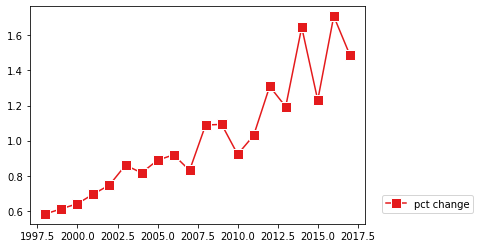

In [57]:
# the percent change over time will be a linear combination of x_1 and x_2
plt.plot(years, np.exp(.5 * x_1 - .25 * x_2), 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='pct change')
plt.legend(loc=(1.05,.05));

In [87]:
# # simulate data
# n = 100

# data = dict(age=np.random.randint(0, 10, size=n)*10,
#             year=np.random.randint(1990, 2010, size=n))
# data = pd.DataFrame(data)

# data['x_1'] = x_1[np.array(data.year-1990)]
# data['x_2'] = x_2[np.array(data.year-1990)]

# data['value'] = (.1 + .001 * data.age) * np.exp(.5 * data.x_1 - .25 * data.x_2)
# data['data_type'] = 'p'

# data['age_start'] = data.age
# data['age_end'] = data.age + 10

# data['area'] = 'all'
# data['sex'] = 'total'

# data['standard_error'] = -99
# data['upper_ci'] = np.nan
# data['lower_ci'] = np.nan
# data['effective_sample_size'] = 1.e8

# data.value = np.clip(data.value, 0, 1)


# # build the dismod_mr model
# dm = dismod_mr.data.ModelData()

# dm.parameters['p'] = dict(parameter_age_mesh=[0,100], level_bounds={'lower': 0.0, 'upper': 1.0},
#                           level_value={'age_after': 100, 'age_before': 0, 'value': 0.},
#                           heterogeneity='Slightly',
#                           fixed_effects={'x_sex': dict(dist='Constant', mu=0)})

# # fit and predict full model
# dm.input_data = data

########################################################



# — your filtered df —
# df.columns == ['age_start','age_end','year_start','year_end',
#                'Sample size','proportion']

# 1) single rename: proportion→value, Sample size→sample_size
data = df.rename(columns={
    'Sample size': 'sample_size',
    'proportion':  'value'
}).copy()

# 2) compute standard error
vals = data['value'].to_numpy(dtype=float)
ns   = data['sample_size'].to_numpy(dtype=float)
data['standard_error'] = np.sqrt(vals * (1 - vals) / ns)

# 3) add the rest of the mandatory columns
data['data_type']             = 'p'
data['area']                  = 'all'
data['sex']                   = 'male'
data['lower_ci']              = np.nan
data['upper_ci']              = np.nan
data['effective_sample_size'] = int(data['sample_size'].iloc[0])

# compute the offset in years, then cast to integer
offset = (data['year'] - 1999).astype(int)

# make sure x_1 and x_2 are numpy arrays (or pandas Series)
x1_arr = np.asarray(x_1)
x2_arr = np.asarray(x_2)

# now index with the integer array
data['x_1'] = x1_arr[offset.values]
data['x_2'] = x2_arr[offset.values]


# 4) reorder exactly as ModelData wants
col_order = [
    'data_type','area','sex',
    'age_start','age_end',
    'year_start','year_end','year',
    'value','standard_error',
    'lower_ci','upper_ci',
    'sample_size','effective_sample_size'
]
data = data[col_order]


# 5) build & fit
dm = dismod_mr.data.ModelData()
dm.parameters['p'] = dict(
    parameter_age_mesh=[0,100],
    level_bounds={'lower':0.0,'upper':1.0},
    level_value={'age_after':100,'age_before':0,'value':0.},
    heterogeneity='Slightly',
    fixed_effects={'x_sex':dict(dist='Constant', mu=0)}
)

# 데이터프레임 칼럼 대신, dm.input_data 에 전달하기 전 한 줄만 남깁니다
data = data.drop(columns='effective_sample_size')

dm.input_data = data

# now you can dm.fit(), dm.predict(), etc.





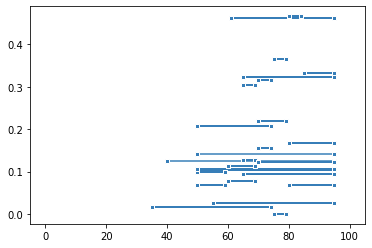

In [82]:
dm.plot('p')

In [ ]:
# 그리고 setup_model 직전에:
dm.input_data.effective_sample_size = float(data['sample_size'].iloc[0])

dm.setup_model('p', rate_model='neg_binom', include_covariates=False)

KeyError: 'effective_sample_size'

In [71]:
dm.fit(how='mcmc', iter=2_000, burn=1_000, thin=1)

NotImplementedError: Need to call .setup_model before calling fit.

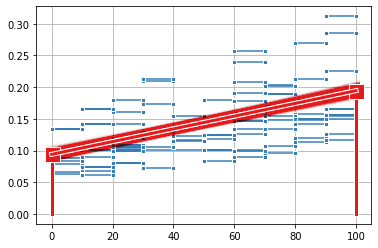

In [53]:
dm.plot('p')
plt.grid();

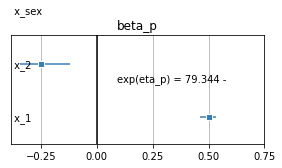

In [10]:
dismod_mr.plot.effects(dm, 'p', figsize=(10,2))
plt.xticks(np.arange(-.25,1,.25))
plt.grid();

This shows the model is hooked up right... the variation in the data is completely explained by the covariates, and the levels and effect coefficients have been recovered from 100 data points.

To use the `dm.predict_for` method, we need to fill in values in `dm.output_template`:

In [11]:
dm.output_template

,data_type,area,sex,year,pop


In [12]:
dm.output_template = pd.DataFrame(dict(year=years, x_1=x_1, x_2=x_2))
dm.output_template['sex'] = 'total'
dm.output_template['pop'] = 1  # pop is important for aggregating multiple areal units, but not relevant for this case
dm.output_template['area'] = 'all'

In [13]:
dm.predict_for('p', 'all', 'total', 2_000).mean()

0.13209321480800162

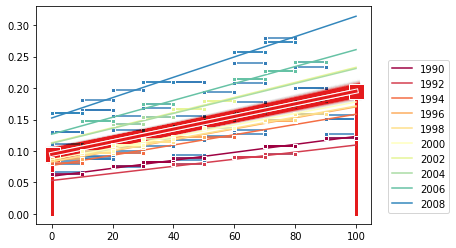

In [14]:
dm.plot()
for y in range(1990,2010,2):
    color = plt.cm.Spectral((y-1990.)/20.)
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=color, label=str(y))
    dismod_mr.plot.data_bars(dm.input_data[dm.input_data.year == y], color=color, label='')
plt.legend(loc=(1.05,.05));

In [15]:
import importlib

In [16]:
importlib.reload(dismod_mr.plot)

<module 'dismod_mr.plot' from '/Users/jeonsang-eon/dismod_mr/src/dismod_mr/plot.py'>

To really see how well this is predicting, we can look at the residuals:

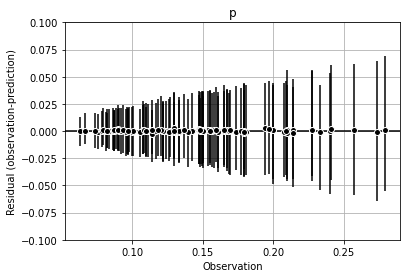

In [17]:
importlib.reload(dismod_mr.plot)

dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

And the output we are really most interested in is how does the predicted percent change year to year compare to the truth

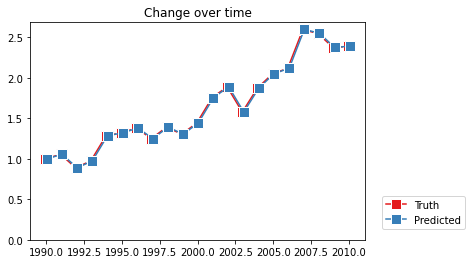

In [18]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years-.05, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years+.05, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

What happy results.  Unfortunately, we never have perfect predictors like this.  If we were forced to make due without x_1 or x_2, what would happen?

For starters, we could have _no_ predictive covariates.  In this case, the predictions for every year will have the same mean, and the uncertainty will be blown up to capture all of the unexplained variation.

In [19]:
dm.input_data = dm.input_data.drop(['x_1', 'x_2'], axis=1)
dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.21
sampling from posterior

CPU times: user 8.26 s, sys: 97.9 ms, total: 8.36 s
Wall time: 8.53 s


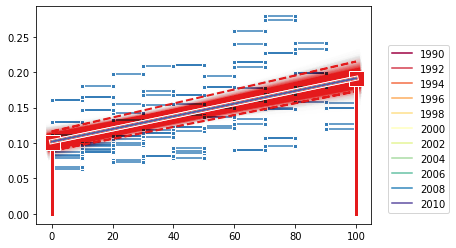

In [20]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

Now the residuals show the unexplained variation:

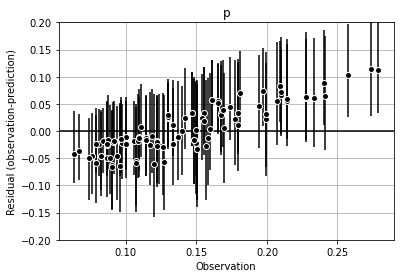

In [21]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.2, ymax=.2);

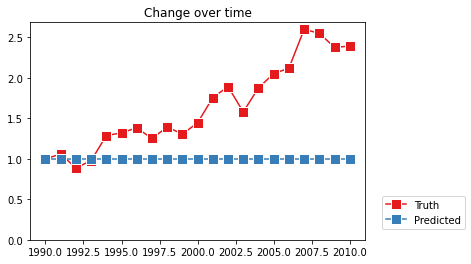

In [22]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

Noting that the values are correlated with time, we could use time as a predictive covariate (appropriately normalized).  This would not be perfect, but it would work pretty well in this case.

In [23]:
dm.input_data['x_year'] = (data.year-2000.) / 10.
dm.output_template['x_year'] = (years-2000.) / 10.

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.07
sampling from posterior

CPU times: user 10.2 s, sys: 188 ms, total: 10.4 s
Wall time: 11.2 s


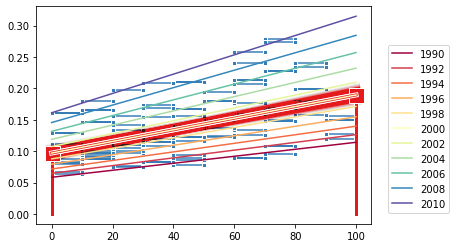

In [24]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

In this case, the residuals are smaller, but not infinitesimal as in the original fit.

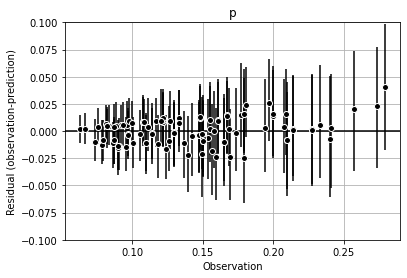

In [25]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

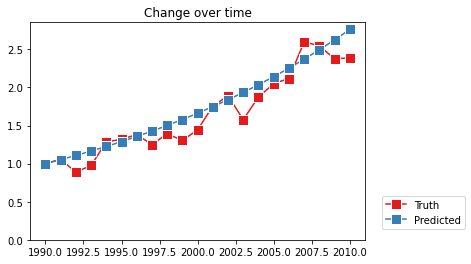

In [26]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

If we had only `x_1`, we could use that as the predictive covariate, and it would work slightly better.

In [27]:
dm.input_data = dm.input_data.drop(['x_year'], axis=1)
dm.input_data['x_1'] = x_1[np.array(data.year-1990)]

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 9.12 s, sys: 85.1 ms, total: 9.21 s
Wall time: 9.43 s


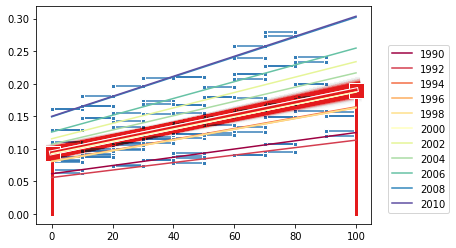

In [28]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

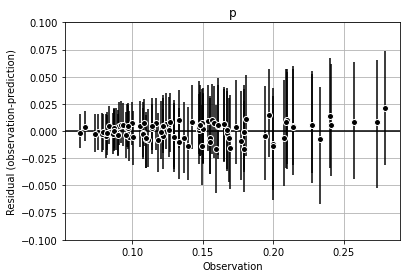

In [29]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

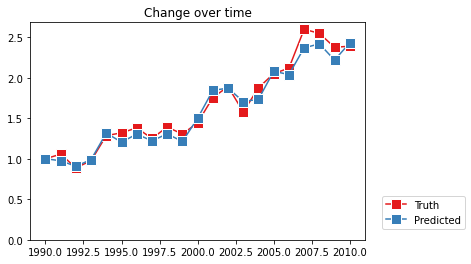

In [30]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

We could also use x_1 and year together, which isn't really to our advantage in this case.

In [31]:
dm.input_data['x_year'] = (data.year-2000.) / 10.

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 9.47 s, sys: 122 ms, total: 9.59 s
Wall time: 9.9 s


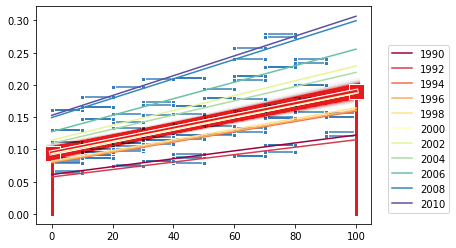

In [32]:
dm.plot()
for y in range(1990,2011,2):
    plt.plot(dm.predict_for('p', 'all', 'total', y).mean(0), color=plt.cm.Spectral((y-1990.)/20.), label=str(y))
    
plt.legend(loc=(1.05,.05));

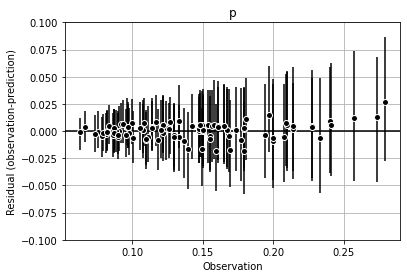

In [33]:
dismod_mr.plot.plot_one_ppc(dm, 'p')
plt.axis(ymin=-.1, ymax=.1);

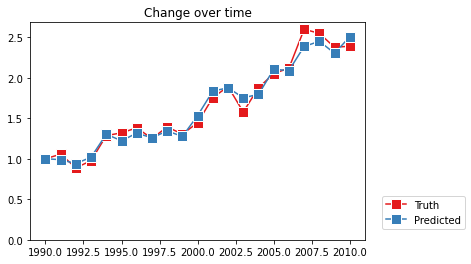

In [34]:
# the percent change over time will be a linear combination of x_1 and x_2
yy = np.exp(.5 * x_1 - .25 * x_2)
yy /= yy[0]
plt.plot(years, yy, 's-', color=dismod_mr.plot.colors[0], mec='w', ms=10, label='Truth')
plt.title('Change over time')

yy = np.array([dm.predict_for('p', 'all', 'total', y).mean() for y in years])
yy /= yy[0]
plt.plot(years, yy,
     's-', color=dismod_mr.plot.colors[1], mec='w', ms=10, label='Predicted')

plt.axis(ymin=0)
plt.legend(loc=(1.05,.05));

Note that including x_year as a covariate when x_1 is already included provides no additional information.  So anything that looks better in this version is actually *overfitting*.

In [35]:
!date

Wed Apr 16 10:29:01 EDT 2025
